In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [10]:
# Attempt to load the dataset with ISO-8859-1 encoding
try:
    data = pd.read_csv('data.csv', encoding='ISO-8859-1')
except Exception as e:
    load_error = str(e)
else:
    load_error = None
    # Display the first few rows of the dataset
    data_head = data.head()

data_head, load_error


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
       InvoiceDate  UnitPrice  CustomerID         Country  
 0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
 1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
 3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 4  12/1/2010 8:26       3.39     17850.0  United Kingdom  ,
 None)

In [11]:
# Handling missing values and duplicates

# Removing rows where value is missing
data_cleaned = data.dropna(subset=['Description', 'CustomerID'])
data_cleaned = data_cleaned[data_cleaned['Description'].str.isupper()]

# Removing duplicate rows
data_cleaned = data_cleaned.drop_duplicates()

# Checking for any anomalies like negative quantities or prices
anomalies = data_cleaned[(data_cleaned['Quantity'] < 0) | (data_cleaned['UnitPrice'] < 0)]

# Displaying the updated dataset information
data_info_updated = {
    "Initial Rows": len(data),
    "Rows after Cleaning": len(data_cleaned),
    "Removed Rows": len(data) - len(data_cleaned),
    "Anomalous Rows": len(anomalies)
}

data_info_updated


{'Initial Rows': 541909,
 'Rows after Cleaning': 401604,
 'Removed Rows': 140305,
 'Anomalous Rows': 8872}

In [12]:
# Data Cleaning

data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

data_cleaned.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [13]:
# Feature Selection
features = ['Description', 'Quantity', 'UnitPrice', 'Country', 'TotalPrice']
target = 'StockCode'

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[features], data_cleaned[target], test_size=0.2, random_state=42)


In [14]:
# Data Transformation
categorical_features = ['Description', 'Country']
continuous_features = ['Quantity', 'UnitPrice', 'TotalPrice']
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuous_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert features to dense NumPy arrays
X_train_array = X_train_transformed.toarray().astype('float32')
X_test_array = X_test_transformed.toarray().astype('float32')

# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Handling unseen labels in the test set
seen_labels = set(label_encoder.classes_)
unseen_labels = set(y_test) - seen_labels
y_test_filtered = y_test[~y_test.isin(unseen_labels)]
X_test_filtered = X_test.loc[y_test_filtered.index]

# Transform the filtered y_test
y_test_encoded = label_encoder.transform(y_test_filtered)

# Convert the filtered test set to NumPy arrays
X_test_array_filtered = preprocessor.transform(X_test_filtered).toarray().astype('float32')
y_test_array = np.array(y_test_encoded).astype('int32')

In [15]:
# Model Building
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_array.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(preprocessor.named_transformers_['cat'].get_feature_names_out()), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_train_array, np.array(y_train_encoded).astype('int32'), epochs=10, batch_size=32, validation_data=(X_test_array_filtered, y_test_array))

# Model Evaluation
loss, accuracy = model.evaluate(X_test_array_filtered, y_test_array)
print(f"Test accuracy: {accuracy}")

# Save the model
model.save('recommendation_model')
loaded_model = load_model('recommendation_model/')

Epoch 1/10
9818/9818 [==============================] - 87s 9ms/step - loss: 1.7344 - accuracy: 0.7549 - val_loss: 0.3565 - val_accuracy: 0.9497
Epoch 2/10
9818/9818 [==============================] - 88s 9ms/step - loss: 0.2884 - accuracy: 0.9567 - val_loss: 0.1676 - val_accuracy: 0.9760
Epoch 3/10
9818/9818 [==============================] - 88s 9ms/step - loss: 0.1651 - accuracy: 0.9733 - val_loss: 0.1127 - val_accuracy: 0.9836
Epoch 4/10
9818/9818 [==============================] - 91s 9ms/step - loss: 0.1247 - accuracy: 0.9795 - val_loss: 0.0911 - val_accuracy: 0.9864
Epoch 5/10
9818/9818 [==============================] - 93s 9ms/step - loss: 0.1050 - accuracy: 0.9824 - val_loss: 0.0807 - val_accuracy: 0.9875
Epoch 6/10
9818/9818 [==============================] - 90s 9ms/step - loss: 0.0949 - accuracy: 0.9837 - val_loss: 0.0744 - val_accuracy: 0.9883
Epoch 7/10
9818/9818 [==============================] - 87s 9ms/step - loss: 0.0876 - accuracy: 0.9847 - val_loss: 0.0704 - val_ac

INFO:tensorflow:Assets written to: recommendation_model\assets


INFO:tensorflow:Assets written to: recommendation_model\assets


In [16]:
unique_items = data_cleaned['Description'].unique().tolist()
unique_items


['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 "POPPY'S PLAYHOUSE BEDROOM ",
 "POPPY'S PLAYHOUSE KITCHEN",
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY ',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS ',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED ',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE ',
 'INFLATAB

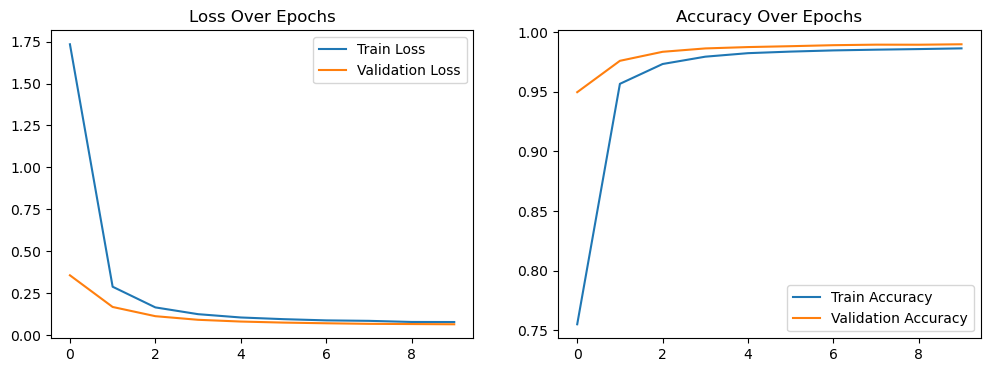

In [20]:
def precision_at_k(y_true, y_pred, k):
    """
    Calculate the precision at k for recommendations.
    
    :param y_true: The actual labels (as integers) for each sample.
    :param y_pred: The predicted scores (as a 2D array) for each sample.
    :param k: The number of top recommendations to consider.
    :return: The average precision at k.
    """
    correct_predictions = 0

    # Iterate over each prediction and corresponding true label
    for true_label, pred_scores in zip(y_true, y_pred):
        # Get indices of the top k predictions
        top_k_preds = np.argsort(pred_scores)[-k:][::-1]

        # Check if the true label is within the top k predictions
        if true_label in top_k_preds:
            correct_predictions += 1

    # Calculate precision
    precision = correct_predictions / len(y_pred)
    return precision


# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()


In [21]:
y_pred = loaded_model.predict(X_test_array_filtered)

# Calculate precision at k
k = 5  
precision = precision_at_k(y_test_array, y_pred, k)


print(f"Precision at {k}: {precision}")

2453/2453 [==============================] - 5s 2ms/step
Precision at 5: 0.9921266864561171


In [22]:
# Save preprocessors
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']